In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
#from scipy.misc import imread
from imageio import imread
from random import randint
import matplotlib.pyplot as plt
import time

# ADD content
# Loading dataset for training and evaluation

In [0]:
train_folder = "C:/Users/Thai Ngoc/Desktop/Fellowship.ai/One shot learning/omniglot-master/data/images_background/"
evaluation_folder = 'C:/Users/Thai Ngoc/Desktop/Fellowship.ai/One shot learning/omniglot-master/data/images_evaluation/'
hyperparameter1_folder = 'C:/Users/Thai Ngoc/Desktop/Fellowship.ai/One shot learning/omniglot-master/data/images_background_small1'
hyperparameter2_folder = 'C:/Users/Thai Ngoc/Desktop/Fellowship.ai/One shot learning/omniglot-master/data/images_background_small2'
save_path = 'C:/Users/Thai Ngoc/Desktop/Fellowship.ai/One shot learning/omniglot-master/data/data_save/'

In [0]:
# Load dataset with input path folder (background and evaluation). Return a list of Alphabet and the corresponding name
def load_dataset(path_dict):
    list_alphabet = list()
    list_name = list()
    #Load each alphabet in the folder
    for alphabet in os.listdir(path_dict):
        #print("Loading alphabet: " + alphabet)
        list_name.append(alphabet)
        alphabet_images = []
        alphabet_path = os.path.join(path_dict, alphabet)
        # Load each letter in the alphabet
        for letter in os.listdir(alphabet_path):
            letter_path = os.path.join(alphabet_path, letter)
            letter_images = []
            #Load 20 images for each letter
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                image = np.expand_dims(image, axis=-1)
                letter_images.append(image)                
            letter_images = np.array(letter_images)
            alphabet_images.append(letter_images)
        alphabet_images = np.array(alphabet_images)
        #print("shape of alphabet", alphabet_images.shape)
        list_alphabet.append(alphabet_images)
    
    return list_alphabet, list_name
                

In [0]:
X_train, name_train = load_dataset(train_folder)
X_hyper1, name_hyper1 = load_dataset(hyperparameter1_folder)
X_hyper2, name_hyper2 = load_dataset(hyperparameter2_folder)
X_eval, name_eval = load_dataset(evaluation_folder)

In [0]:
#Save datasets into file for next training  or loading on google colab

with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X_train, name_train),f)
    
with open(os.path.join(save_path,"hyper1.pickle"), "wb") as f:
    pickle.dump((X_hyper1, name_hyper1),f)
    
with open(os.path.join(save_path,"hyper2.pickle"), "wb") as f:
    pickle.dump((X_hyper2, name_hyper2),f)
    
with open(os.path.join(save_path,"evaluation.pickle"), "wb") as f:
    pickle.dump((X_eval, name_eval),f)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Load datasets from saved file (do not need load from directories)
save_path = '/content/drive/My Drive/data'
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (X_train, name_train) = pickle.load(f)

with open(os.path.join(save_path, "hyper1.pickle"), "rb") as f:
    (X_hyper1, name_hyper1) = pickle.load(f)
    
with open(os.path.join(save_path, "hyper2.pickle"), "rb") as f:
    (X_hyper2, name_hyper2) = pickle.load(f)
    
with open(os.path.join(save_path, "evaluation.pickle"), "rb") as f:
    (X_eval, name_eval) = pickle.load(f)    

In [0]:
print((X_train[1]).shape)

(29, 20, 105, 105, 1)


In [0]:
print(name_eval)

['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG']


# Construct model for training

In [0]:
def initialize_weights(shape, dtype=None):
    return tf.keras.backend.random_normal(shape, mean=0, stddev=0.01, dtype=dtype)
def initialize_bias(shape, dtype=None):
    return tf.keras.backend.random_normal(shape, mean=0.5, stddev=0.01, dtype=dtype)

In [0]:
def siamese_model(input_shape):
    input_left = tf.keras.Input(input_shape)
    input_right = tf.keras.Input(input_shape)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, 10, activation='relu', input_shape=input_shape,
                                     kernel_initializer=initialize_weights, bias_initializer=initialize_bias, 
                                     kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    model.add(tf.keras.layers.MaxPool2D(2))
    model.add(tf.keras.layers.Conv2D(128, 7, activation='relu',
                                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                                    kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    model.add(tf.keras.layers.MaxPool2D(2))
    model.add(tf.keras.layers.Conv2D(128,4, activation='relu',
                                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                                    kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    model.add(tf.keras.layers.MaxPool2D(2))
    model.add(tf.keras.layers.Conv2D(256, 4, activation='relu',
                                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                                    kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation='sigmoid',
                                  kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                                  kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    encode_left = model(input_left)
    encode_right = model(input_right)
    L1_layer = tf.keras.layers.Lambda(lambda tensor: tf.keras.backend.abs(tensor[0]-tensor[1]))
    L1_distance = L1_layer([encode_left, encode_right])
    L1_distance_dropout = tf.keras.layers.Dropout(0.4)(L1_distance)
    output = tf.keras.layers.Dense(1, activation='sigmoid',
                                  kernel_initializer=initialize_weights,bias_initializer=initialize_bias,
                                  kernel_regularizer=tf.keras.regularizers.l2(1e-3))(L1_distance)
    siamese_cnn = tf.keras.Model(inputs=[input_left, input_right], outputs=output)
    return siamese_cnn

In [0]:
model = siamese_model((105,105,1))
model.summary()

In [0]:
optimizer = tf.keras.optimizers.Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18020310713358633849
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8838083554845084104
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2576655622763335523
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15611999570529470547
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Get batch for training model

In [0]:
def generateOneTrial(data_type = "train"):
    if (data_type=='train'):
        X = X_train
        name_class = name_train
    if (data_type=='evaluation'):
        X = X_eval
        name_class = name_eval
    if (data_type=='hyper1'):
        X = X_hyper1
        name_class = name_hyper1
    if (data_type=='hyper2'):
        X = X_hyper2
        name_class = name_hyper2
     
    data = []
    len_alpha = len(X)  # Number of alphabets in training set   
    alph = np.random.randint(len_alpha) # Choose randomly  an alphabet
    len_char = X[alph].shape[0] # Number of characters in the alphabet
    characters = np.random.choice(len_char, size =2, replace = False) # Choose randomly two distint character in the alphabet
    len_example = X[alph].shape[1] # Number of examples for each character
    examples = np.random.choice(len_example, size = 2, replace = False) # Choose randomly two distint drawers
    img_true = X[alph][characters[0]][examples[0]]
    img_positive = X[alph][characters[0]][examples[1]]
    img_negative = X[alph][characters[1]][examples[0]]
    #data.append([img_true, img_positive, img_negative]) 
    data.append(img_true)
    data.append(img_positive)
    data.append(img_negative)
    return data

In [0]:
data = generateOneTrial('train')
data = np.array(data)

In [0]:
data.shape

(3, 105, 105, 1)

In [0]:
def batch_generate(size, data_type = 'train'):
    w, h = X_train[1].shape[2], X_train[1].shape[3]
    data = [np.zeros((size*2, h, w,1)) for i in range(2)]
    label = np.zeros((size*2,))
    for i in range(size):
        trial = generateOneTrial(data_type)
        trial_true = trial[0]
        trial_positive = trial[1]
        trial_negative = trial[2]
        data[0][2*i] = trial_true
        data[1][2*i] = trial_positive
        data[0][2*i+1] = trial_true
        data[1][2*i+1] = trial_negative
    for i in range(size):
        label[i*2+1] = 1
    return data, label

In [0]:
data, label = batch_generate(12)

In [0]:
print(data[1].shape)

(24, 105, 105, 1)


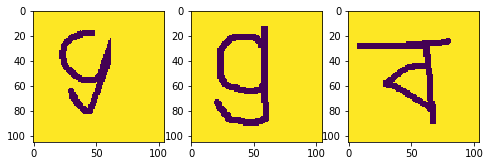

In [0]:
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 1
image1=data[0][10]
image2=data[1][10]
image3=data[1][5]
fig.add_subplot(rows, columns, 1)
plt.imshow(image1.reshape(105,105))
fig.add_subplot(rows, columns, 2)
plt.imshow(image2.reshape(105,105))
fig.add_subplot(rows, columns, 3)
plt.imshow(image3.reshape(105,105))
plt.show()

In [0]:
def generate_one_shot_evaluation(N_way=20, data_type = "evaluation"):
    if (data_type == "train"):
      X = X_train
    else:
      X = X_eval
    len_val = len(X)
    while True:
      alph = np.random.randint(len_val) # Choose randomly one alphabet
      len_characters = X[alph].shape[0] # Number of characters in the alphabet
      if (len_characters>=N_way):
        break    
    characters = np.random.choice(len_characters, size=N_way, replace = False) # Choose N_way distint characters in the alphabet
    len_example = X[alph].shape[1] # Number of examples for each character
    examples = np.random.choice(len_example, size = 2, replace = False) # Choose randomly two distint drawers
    train_img = []
    test_img = []
    for i in range(20):
        test_img.append(X[alph][characters[i]][examples[0]])
        train_img.append(X[alph][characters[i]][examples[1]])
    test_img = np.array(test_img)
    train_img = np.array(train_img)
    return test_img, train_img

In [0]:
n_accuracy = 0
for i in range(10):  
  test_img, train_img = generate_one_shot_evaluation(data_type='train')
  for j in range(20):
    test_img_N_way = np.array([test_img[j] for k in range(20)])
    data_test = [test_img_N_way, train_img]
    predict_value = model.predict(data_test)
    if (j==np.argmin(predict_value)):
      n_accuracy = n_accuracy+1
accuracy = n_accuracy/(10*20)
print(accuracy)

0.05


In [0]:
N_way = 20
def test_one_shot(iteration, data_type = 'evaluation'):
    n_accuracy = 0
    for i in range(iteration):
        test_img, train_img = generate_one_shot_evaluation(20, data_type)
        for k in range(20):
            test_image_N_way = np.array([test_img[k] for m in range(20)])
            data_train = [test_image_N_way, train_img]
            predict_value = model.predict(data_train)
            if (k==np.argmin(predict_value)):
              n_accuracy+=1              
    accuracy = n_accuracy/(iteration*N_way)
    return accuracy

In [0]:
print(test_one_shot(10))

0.685


 **TRAINING MODEL**

In [0]:

model.load_weights(os.path.join(save_path, 'weights.best.h5'))
t_start = time.time()
for i in range(200000):
    data, label = batch_generate(16)
    loss = model.train_on_batch(data, label)    
    if i%2000==0:
        t_end = time.time()
        print("Time  for {0} iteration: {1}".format(i, (t_end-t_start)/60))
        print('Loss: ', loss)
        model.save_weights(os.path.join(save_path, 'weights.best.h5'))
        acc = test_one_shot(20)
        print("Test accuracy: ", acc)
#model.save_weights(os.path.join(save_path, 'weights.best.h5')) 

In [0]:
acc = test_one_shot(100, data_type="evaluation")
print(acc)

0.6395


**Model with Triplet loss**

In [0]:
def model_triplet_example(input_shape):
    input_true = tf.keras.Input(input_shape)
    input_positive = tf.keras.Input(input_shape)
    input_negative = tf.keras.Input(input_shape)
    model = tf.keras.models.Sequential()
    #model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(64, 10, activation='relu', input_shape=input_shape,
                                     kernel_initializer=initialize_weights, bias_initializer=initialize_bias, 
                                     kernel_regularizer=tf.keras.regularizers.l2(2e-4)))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D(2))
    model.add(tf.keras.layers.Conv2D(128, 7, activation='relu',
                                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-2)))
    model.add(tf.keras.layers.MaxPool2D(2))
    model.add(tf.keras.layers.Conv2D(128,4, activation='relu',
                                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-2)))
    model.add(tf.keras.layers.MaxPool2D(2))
    model.add(tf.keras.layers.Conv2D(256, 4, activation='relu',
                                    kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                                    kernel_regularizer=tf.keras.regularizers.l2(1e-2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation='sigmoid',
                                  kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                                  kernel_regularizer=tf.keras.regularizers.l2(1e-4)))
    #model.add(tf.keras.layers.Dropout(0.3))
    emb_true = model(input_true)
    emb_pos = model(input_positive)
    emb_neg = model(input_negative)
    dist_layer = tf.keras.layers.Lambda(lambda tensor: tf.abs(tensor[0]-tensor[1]), name = 'distance')
    dist_pos = dist_layer([emb_true, emb_pos])
    dist_neg = dist_layer([emb_true, emb_neg])
    last_layer = tf.keras.layers.Dense(1, activation='sigmoid', name ='last_layer_triplet')
    pred_pos = last_layer(dist_pos)
    pred_neg = last_layer(dist_neg)
    loss_layer = tf.keras.layers.Lambda(lambda tensor: tf.square(tensor[0])+tf.square(1-tensor[1]))
    loss = loss_layer([pred_pos, pred_neg])
    triplet_model = tf.keras.Model(inputs=[input_true, input_positive, input_negative], outputs = loss)
    return triplet_model

In [11]:
model_triplet = model_triplet_example((105,105,1))
model_triplet.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38947648    input_1[0]

In [0]:
def triplet_loss_example(y_true, y_pred):
    pred_pos, pred_neg = y_pred[0], y_pred[1]
    #loss = tf.square(pred_pos) + tf.square(1-pred_neg)
    loss = tf.maximum(pred_pos-pred_neg+0.2, 0)
    return loss
def identity_loss_example(y_true, y_pred):
    return y_pred

In [0]:
optimizer_triplet = tf.keras.optimizers.Adam(lr = 0.0000003)
model_triplet.compile(loss=identity_loss_example, optimizer=optimizer_triplet)

In [0]:
def generate_batch_triplet(size, data_type = "train"):
    w, h = X_train[1].shape[2], X_train[1].shape[3]
    batch_triplet = [np.zeros((size,w,h,1)) for i in range(3)]
    for i in range(size):
        one_triplet = generateOneTrial(data_type=data_type)
        batch_triplet[0][i] = one_triplet[0]
        batch_triplet[1][i] = one_triplet[1]
        batch_triplet[2][i] = one_triplet[2]
    output = np.zeros((size,))
    return batch_triplet, output

In [0]:
batch_triplet_trial, output = generate_batch_triplet(50, data_type = "train")

In [16]:
model_triplet.load_weights(os.path.join(save_path, 'weights.best_triplet_last.h5'))
start_time = time.time()
score = 0
iteration_best = 0
for i in range(1000):
    batch_triplet_trial, output = generate_batch_triplet(32)
    loss = model_triplet.train_on_batch(batch_triplet_trial, output)
    if i%200 ==0:
      end_time = time.time()
      print('Iteration {} with time {}'.format(i, (end_time-start_time)/60))
      print("Loss: ", loss)
      acc_triplet = test_one_shot_triplet(100)
      print('Accuracy:', acc_triplet)
      if (score<acc_triplet):
        print("Best score at iteration {} is {}".format(i,acc_triplet))
        model_triplet.save_weights(os.path.join(save_path, 'weights.best_triplet{}.h5'.format(i)))
        score = acc_triplet
        iteration_best = i
model_triplet.save_weights(os.path.join(save_path, 'weights.best_triplet_last.h5'))
print("Best score", score)
print("Iteration", iteration_best)

Iteration 0 with time 0.09773690303166707
Loss:  0.0143231
Accuracy: 0.704
Best score at iteration 0 is 0.704
Iteration 200 with time 2.8737351179122923
Loss:  0.013851965
Accuracy: 0.684
Iteration 400 with time 5.499474442005157
Loss:  0.014246955
Accuracy: 0.688
Iteration 600 with time 8.120214180151622
Loss:  0.013879222
Accuracy: 0.7025
Iteration 800 with time 10.742629810174305
Loss:  0.014509976
Accuracy: 0.6865
Best score 0.704
Iteration 0


In [0]:
model_triplet.save_weights(os.path.join(save_path, 'weights.best_triplet_last.h5'))

In [0]:
def test_one_shot_triplet(iteration, data_type = 'evaluation'):
    n_accuracy = 0
    for i in range(iteration):
        test_img, train_img = generate_one_shot_evaluation(20, data_type)
        for k in range(20):
            test_image_N_way = np.array([test_img[k] for m in range(20)])
            data_train = [train_img, test_image_N_way, train_img]
            predict_value = model_triplet.predict(data_train)
            if (k==np.argmin(predict_value)):
              n_accuracy+=1              
    accuracy = n_accuracy/(iteration*N_way)
    return accuracy

In [0]:
model_triplet.load_weights(os.path.join(save_path, 'weights.best_triplet7200.h5'))
acc_triplet = test_one_shot_triplet(100, data_type='evaluation')
print(acc_triplet)

0.693


In [0]:
model_triplet.predict(batch_triplet_trial)

In [0]:
with open(os.path.join(save_path, "Evaluation_full.pickle"), "rb") as f:
    (X_eval_train, name_evaluation_full) = pickle.load(f)

In [19]:
X_eval_train = np.expand_dims(X_eval_train, axis=-1)
print(X_eval_train.shape)

(659, 20, 105, 105, 1)


In [0]:
def generateOneTrial_full(data_type = "evaluation"):
    if (data_type=='train'):
        X = X_train
        name_class = name_train
    if (data_type=='evaluation'):
        X = X_eval_train
        name_class = name_evaluation_full  
    if (data_type=='hyper1'):
        X = X_hyper1
        name_class = name_hyper1
    if (data_type=='hyper2'):
        X = X_hyper2
        name_class = name_hyper2
     
    data = []
    len_alpha = X.shape[0]  # Number of characters in training set   
    characters = np.random.choice(len_alpha, size =2, replace = False) # Choose randomly two distint character in the alphabet
    examples = np.random.choice(X.shape[1], size = 2, replace = False) # Choose randomly two distint drawers
    img_true = X[characters[0]][examples[0]]
    img_positive = X[characters[0]][examples[1]]
    img_negative = X[characters[1]][examples[0]]
    #data.append([img_true, img_positive, img_negative]) 
    data.append(img_true)
    data.append(img_positive)
    data.append(img_negative)
    return data

In [0]:
data_full = generateOneTrial_full()

In [0]:
def generate_one_shot_evaluation_full(N_way=20, data_type = "evaluation"):
    if (data_type == "train"):
      X = X_train
    else:
      X = X_eval_train
    len_characters = X.shape[0]
    characters = np.random.choice(len_characters, size=N_way, replace = False) # Choose N_way distint characters in the alphabet
    len_example = X.shape[1] # Number of examples for each character
    examples = np.random.choice(len_example, size = 2, replace = False) # Choose randomly two distint drawers
    train_img = []
    test_img = []
    for i in range(N_way):
        test_img.append(X[characters[i]][examples[0]])
        train_img.append(X[characters[i]][examples[1]])
    test_img = np.array(test_img)
    train_img = np.array(train_img)
    return test_img, train_img

In [22]:
test_img, train_img = generate_one_shot_evaluation_full()
print(test_img.shape)
print(train_img.shape)

(20, 105, 105, 1)
(20, 105, 105, 1)


In [0]:
def test_one_shot_triplet_full(iteration, N_way = 20, data_type = 'evaluation'):
    n_accuracy = 0
    for i in range(iteration):
        test_img, train_img = generate_one_shot_evaluation_full(N_way, data_type)
        for k in range(N_way):
            test_image_N_way = np.array([test_img[k] for m in range(N_way)])
            data_train = [train_img, test_image_N_way, train_img]
            predict_value = model_triplet.predict(data_train)
            if (k==np.argmin(predict_value)):
              n_accuracy+=1              
    accuracy = n_accuracy/(iteration*N_way)
    return accuracy

In [0]:
loss = test_one_shot_triplet_full(50, N_way=600)
print(loss)